# Project 1

## Project description

S-BIAD1398 contains images of human embryos treated with different drugs. Because these drugs are soluble in DMSO, embryos treated with DMSO alone are used as a control. However, at high concentrations DMSO has been shown to affect the shape of cell nuclei. The goal of this project is to find out if DMSO treatment is affecting nuclear morphology in these embryos. Using nuclear segmentation models such as CellPose, can you compare the shape of the nucleus (aspect ratio, area…) between untreated embryos (“characterisation” dataset) and DMSO treated embryos (“inhibitor treatment” dataset)?

## Setup

### Google Colab

In [ ]:
!pip install --quiet zarr cellpose

### Import necessary dependencies

In [ ]:
import dask.array as da
import zarr
from cellpose import models, plot
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import regionprops, regionprops_table
import pandas as pd

### Images from S-BIAD1398 (BioImage Archive)

* Entry page: https://www.ebi.ac.uk/biostudies/BioImages/studies/S-BIAD1398
* License: CC0

Images of embryos that were not treated with DMSO

In [247]:
untreated_images = (
    "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1398/1771b268-07ab-4eec-952d-6ff42c0ac845/2d2c82ef-1fa0-4a53-b3a4-38c764519b44.ome.zarr/0",
    "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1398/bdfa3385-bcb8-455e-87aa-a9b833b50bda/84d03b11-3fdd-4244-becb-ac1d89a98cf6.ome.zarr/0",
    "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1398/c571b1c4-261e-4ed4-9d81-d1abe41bc284/ec279ac6-cf24-4558-bbcf-47b559e3985b.ome.zarr/0"
)

Images of embryos treated with DMSO

In [248]:
DMSO_images = (
    "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1398/65b70005-bace-48b0-ad34-81e1f1e088e7/57519785-020e-46cd-920e-a158ed3d7427.ome.zarr/0",
    "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1398/8ae28248-f695-4669-9d33-cf9de053c10c/7e470927-d065-4890-ac5f-69348f577249.ome.zarr/0"
)

### Helper methods

Function to load zarr images

In [249]:
def load_ome_zarr_from_uri(uri, path_key='0'):
    array_uri = f"{uri}/{path_key}"
    
    return da.from_zarr(array_uri)

Function to select a single plane from a multidimensional image

In [250]:
def select_single_plane(array, t, z, c):
    """Select a single plane from a lazy array, load and return it."""

    return array[t, c, z, :, :].compute()

Function to perform analysis

In [251]:
def measure_nuclear_properties(single_plane_bia,model):
    cellpose_masks_bia, flows_bia, styles, diams = model.eval(single_plane_bia, diameter=None, channels=[0, 0])
    regions = regionprops(cellpose_masks_bia)
    props = regionprops_table(
        cellpose_masks_bia,
        properties=('area', 'feret_diameter_max', 'axis_major_length', 'axis_minor_length'),
    )
    ar = props['axis_major_length']/props['axis_minor_length']
    props.update({'aspect_ratio': ar})
    return cellpose_masks_bia, flows_bia, props

### Load CellPose trained model

In [252]:
model = models.Cellpose(gpu=False, model_type='cyto')

### Select range of slices to analyise

In [253]:
z_range=range(22,25)

### Analyse untreated embryos

time = 1, channels = 5, z = 44, y = 1024, x = 1024


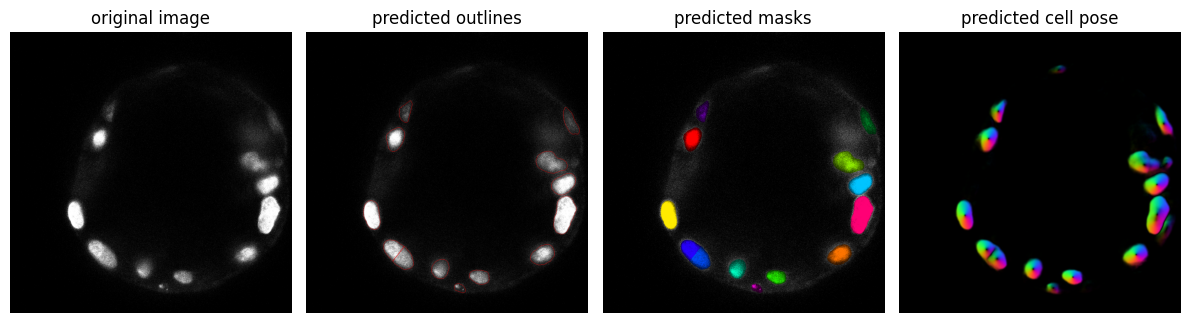

time = 1, channels = 5, z = 58, y = 1024, x = 1024


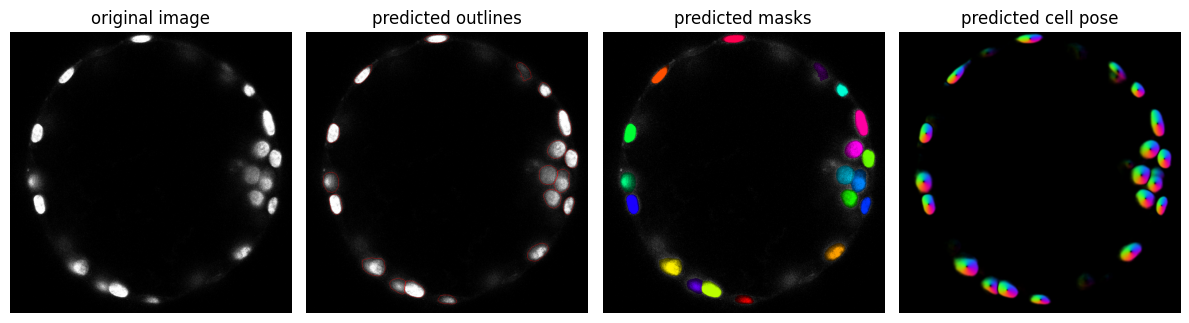

time = 1, channels = 4, z = 84, y = 1024, x = 1024


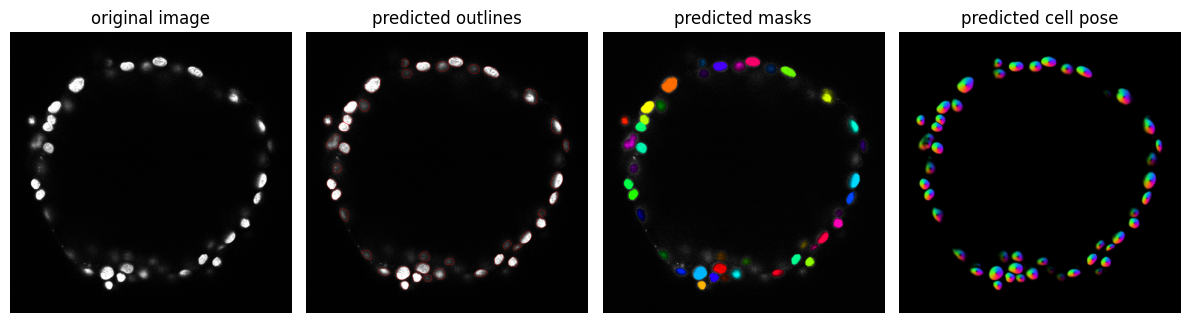

In [254]:
results = {key: [] for key in ['area', 'feret_diameter_max', 'axis_major_length', 'axis_minor_length', 'aspect_ratio']}

for bia_uri in untreated_images:
    bia_array = load_ome_zarr_from_uri(bia_uri)
    print("time = {}, channels = {}, z = {}, y = {}, x = {}".format(*bia_array.shape))
    z_means = {key: [] for key in ['area', 'feret_diameter_max', 'axis_major_length', 'axis_minor_length', 'aspect_ratio']}
    for zz in z_range:#range(bia_array.shape[2]): 
        single_plane_bia = select_single_plane(bia_array, t=0, z=zz, c=0)

        # Measure nuclear properties
        cellpose_masks_bia, flows_bia, props = measure_nuclear_properties(single_plane_bia,model)
        
        props_means = {key: np.mean(value) for key, value in props.items()} # mean of all the nuclei per z plane
        
        # Append per z-plane means
        for key in z_means:
            z_means[key].append(props_means[key]) # stores the means for of all the nuclei per z plane for 1 embryo
    
    # Compute mean across all z-planes (per embryo)
    e_means = {key: np.mean(value) for key, value in z_means.items()} # mean of all the nuclei per embryo
    
    # Append per-embryo means to results
    for key in results:
            results[key].append(e_means[key]) # stores the means for of all the nuclei per embryo

    # Plot example segmentation for the last z plane analysed
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, single_plane_bia, cellpose_masks_bia, flows_bia[0], channels=[0, 0])
    plt.tight_layout()
    plt.show()

# Final results dictionary
results_untreated = results

### Analyse DMSO treated embryos

time = 1, channels = 5, z = 72, y = 1024, x = 1024


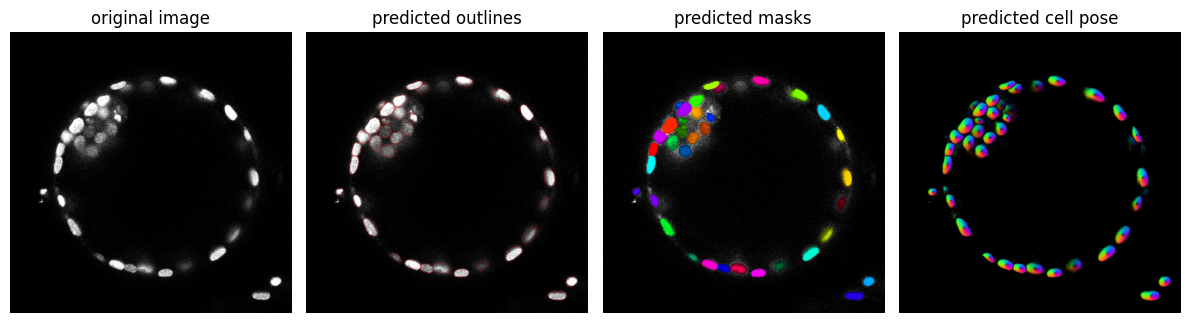

time = 1, channels = 5, z = 67, y = 1024, x = 1024


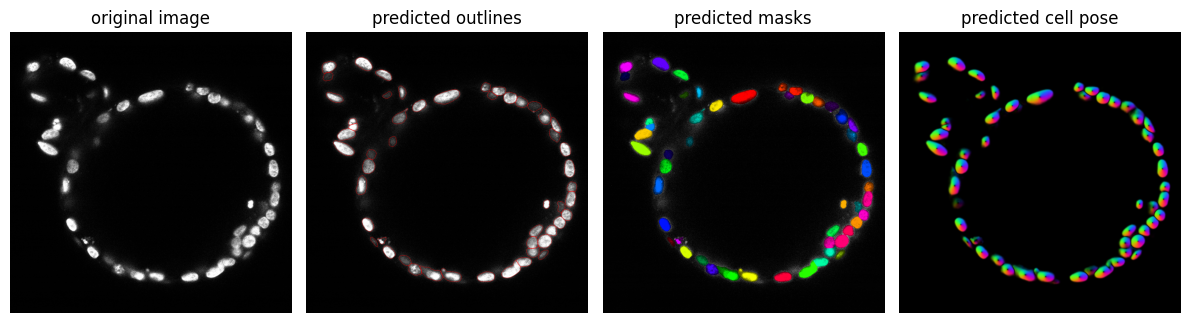

In [255]:
results = {key: [] for key in ['area', 'feret_diameter_max', 'axis_major_length', 'axis_minor_length', 'aspect_ratio']}

for bia_uri in DMSO_images:
    bia_array = load_ome_zarr_from_uri(bia_uri)
    print("time = {}, channels = {}, z = {}, y = {}, x = {}".format(*bia_array.shape))

    z_means = {key: [] for key in ['area', 'feret_diameter_max', 'axis_major_length', 'axis_minor_length', 'aspect_ratio']}

    for zz in z_range:#range(bia_array.shape[2]): 
        single_plane_bia = select_single_plane(bia_array, t=0, z=zz, c=0)

        # Measure nuclear properties
        cellpose_masks_bia, flows_bia, props = measure_nuclear_properties(single_plane_bia,model)

        props_means = {key: np.mean(value) for key, value in props.items()} # mean of all the nuclei per z plane
        
        # Append per z-plane means
        for key in z_means:
            z_means[key].append(props_means[key]) 
    
    # Compute mean across all z-planes (per embryo)
    e_means = {key: np.mean(value) for key, value in z_means.items()} 
    
    # Append per-embryo means to results
    for key in results:
            results[key].append(e_means[key]) 

    # Plot example segmentation for the last z plane analysed
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, single_plane_bia, cellpose_masks_bia, flows_bia[0], channels=[0, 0])
    plt.tight_layout()
    plt.show()

# Final results dictionary
results_dmso = results

### Print results

In [263]:
pd.DataFrame.from_dict(results_untreated)

,area,feret_diameter_max,axis_major_length,axis_minor_length,aspect_ratio
0,4512.976557,97.310865,96.583883,58.920814,1.669459
1,2846.934783,76.715181,75.459693,48.263229,1.659678
2,1158.647406,46.224496,45.015874,32.263890,1.409939


In [264]:
pd.DataFrame.from_dict(results_dmso)

,area,feret_diameter_max,axis_major_length,axis_minor_length,aspect_ratio
0,1556.330952,58.263949,57.183244,34.596105,1.703629
1,1576.445416,57.379094,56.360208,35.572816,1.609633


### Plot results

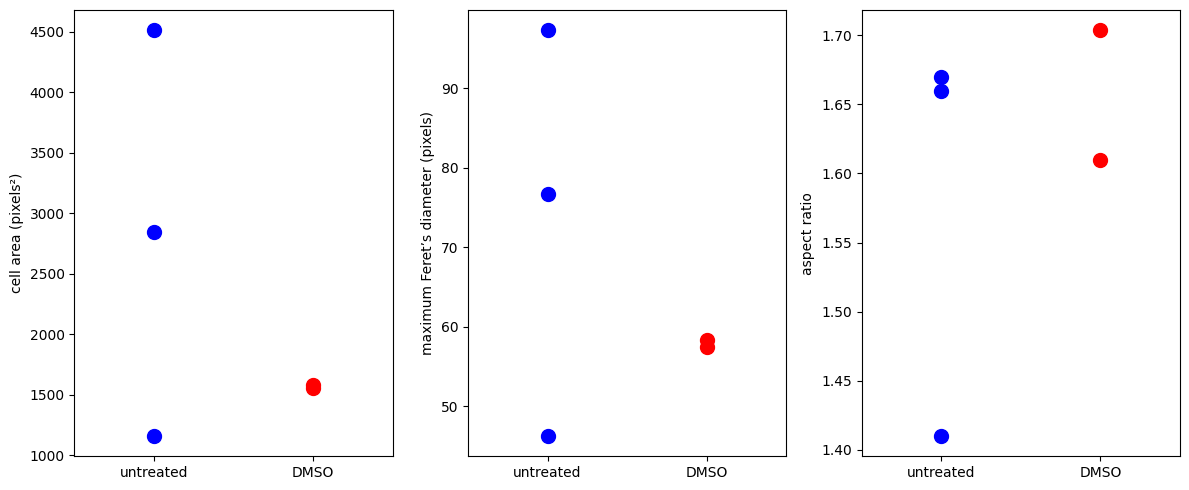

In [ ]:
# Data
area1 = results_untreated['area']
area2 = results_dmso['area']

feret1 = results_untreated['feret_diameter_max']
feret2 = results_dmso['feret_diameter_max']

ar1 = results_untreated['aspect_ratio']
ar2 = results_dmso['aspect_ratio']

x_positions = np.linspace(1.5, 2.5, 2)  
x1 = np.full(len(area1), x_positions[0])  
x2 = np.full(len(area2), x_positions[1])  
 
fig, ax = plt.subplots(1, 3,figsize=(12, 5))  

# area
ax[0].scatter(x1, area1, color='b',  s=100) 
ax[0].scatter(x2, area2, color='r',  s=100)  
ax[0].set_xticks(x_positions, ["untreated", "DMSO"])  
ax[0].set_xlim(x_positions[0] - 0.5, x_positions[1] + 0.5)  
ax[0].set_ylabel("cell area (pixels²)")

# feret diameter
ax[1].scatter(x1, feret1, color='b',  s=100) 
ax[1].scatter(x2, feret2, color='r',  s=100)  
ax[1].set_xticks(x_positions, ["untreated", "DMSO"])  
ax[1].set_xlim(x_positions[0] - 0.5, x_positions[1] + 0.5)  
ax[1].set_ylabel("maximum Feret’s diameter (pixels)")

# aspect ratio
ax[2].scatter(x1, ar1, color='b',  s=100) 
ax[2].scatter(x2, ar2, color='r',  s=100)  
ax[2].set_xticks(x_positions, ["untreated", "DMSO"])  
ax[2].set_xlim(x_positions[0] - 0.5, x_positions[1] + 0.5)  
ax[2].set_ylabel("aspect ratio")


plt.tight_layout()
plt.show()


Conclusion: The results suggest that any differences between untreated and DMSO treated embryos may arise from the nucleus size rather than morphology. Although some differences may be observed at this stage, adding more embryos for each condition will be necessary to be able to run any statistical analysis

Futhermore, differences obseved here could be due to the different days post fertilisation stated in the image metadata. Further analysis will be necessary to rule out effects due to developmental time.